In [2]:
from backend.daps.data import Devices, Speakers
from backend.daps.loader import DAPSLoader
from backend.audio_to_spectrogram_converter import AudioToSpectrogramConverter
from backend.tsrc.loader import TSRCLoader
from backend.tsrc.data import Environments
from backend import audio_data

import PIL
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import librosa

from ipywidgets import widgets
from ipywidgets import interactive
from IPython.display import Audio
from tqdm import tqdm

import cv2
import os

In [339]:
path_to_spectrograms_raw = "../data/v2/tsrc_sprectrograms_without_clean"
path_to_spectrograms_denoised = "../data/v2/tsrc_sprectrograms"
path_to_spectrograms_audio = "../data/v2/tsrc_train_test/"

%load_ext autoreload
%autoreload 2

sns.set_theme(rc={'figure.figsize':(20,6)})

sns.set_theme(context='notebook', style = "white", palette=None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Reading data
    </div>

In [360]:
class SpectrogramData():
    def __init__(self, file_path : str, speaker_id : str, recording_no : int , train_validaton_test : str, class_id : int):
        self.file_path = file_path
        self.speaker_id = speaker_id
        self.recording_no = recording_no
        self.train_validaton_test = train_validaton_test
        self.class_id = class_id

class SpectrogramLoader():
        
    @staticmethod
    def load_data(path):
        objects_list = []
        
        for subdir, dirs, files in os.walk(path):
            if dirs is not None:
                for file in files:
                    file_path = os.path.join(subdir, file)
                    file_path = os.path.normpath(file_path)
                    class_id = file_path.split('\\')[-2]
                    train_validaton_test = file_path.split('\\')[-3]
                    speaker_id = file[:8]
                    recording_no = file.removesuffix(".png").split("_")[1]

                    data_object = SpectrogramData(file_path=file_path,
                                                  speaker_id=speaker_id,
                                                  recording_no=int(recording_no),
                                                  train_validaton_test=train_validaton_test,
                                                  class_id=int(class_id))
                    objects_list.append(data_object)
        
        return objects_list
    
class AudioLoader():
        
    @staticmethod
    def __load_audio(file_path: str, train_validaton_test : str, speaker_id : str, class_id : str) -> audio_data.AudioData:
        y, sr = librosa.load(file_path)
        return audio_data.AudioData(y, sr, train_validaton_test, speaker_id, class_id)
    
    @staticmethod
    def load_data(path):
        objects_list = []
        
        for subdir, dirs, files in os.walk(path):
            if dirs is not None:
                for file in tqdm(files):
                    file_path = os.path.join(subdir, file)
                    file_path = os.path.normpath(file_path)
                    train_validaton_test = file_path.split('\\')[-3]
                    speaker_id = file.split('_')[1]
                    class_id = file_path.split('\\')[-2]

                    data_object = AudioLoader.__load_audio(file_path=file_path,
                                                  train_validaton_test=train_validaton_test,
                                                  speaker_id=speaker_id,
                                                  class_id=int(class_id))
                    objects_list.append(data_object)
        
        return objects_list

In [361]:
def color_histogram(file_path, black_threshold):   
    img = cv2.imread(file_path)
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    colors = ['r', 'g', 'b']
    histograms = []
    
    mask = np.logical_not(np.all(imgRGB < black_threshold, axis=2)).astype(np.uint8)
    for i, color in enumerate(colors):
        hist = cv2.calcHist([imgRGB], [i], mask, [256], [0,256])
        histograms.append(hist)

    return histograms
    
def plot_color_histogram(file_path, black_threshold):
    img = cv2.imread(file_path)
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #plt.figure()
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(imgRGB)
    
    colors = ['r', 'g', 'b']
    histograms = []
    
    mask = np.logical_not(np.all(imgRGB < black_threshold, axis=2)).astype(np.uint8)
    for i, color in enumerate(colors):
        hist = cv2.calcHist([imgRGB], [i], mask, [256], [0,256])
        histograms.append(hist)
        axes[1].plot(hist, color,)
        
    plt.xlabel("Pixel intensity")
    plt.ylabel("# of Pixels")
    plt.show()
    
def grey_histogram(file_path, black_threshold):   
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    mask = (img > black_threshold).astype(np.uint8)
    hist = cv2.calcHist([img], [0], mask, [256], [0,256])

    return hist

def plot_grey_histogram(file_path, black_threshold):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    #plt.figure()
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img, cmap='gray')
    
    
    mask = (img > black_threshold).astype(np.uint8)
    hist = cv2.calcHist([img], [0], mask, [256], [0,256])
    axes[1].plot(hist)
        
    plt.xlabel("Pixel intensity")
    plt.ylabel("# of Pixels")
    plt.show()

In [341]:
audio_data = AudioLoader().load_data(path_to_spectrograms_audio)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 718.12it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████| 15587/15587 [00:23<00:00, 661.81it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 618.91it/s]


In [342]:
spectrogram_data_raw = SpectrogramLoader().load_data(path_to_spectrograms_raw)
spectrogram_data_denoised = SpectrogramLoader().load_data(path_to_spectrograms_denoised)

class_id_list = []
sample_len_list = []
sample_rate_list = []
speaker_id_list = []
train_validaton_test_list = []

for audio in audio_data:
    class_id_list.append(audio.class_id)
    sample_len_list.append(len(audio.samples))
    sample_rate_list.append(audio.sample_rate)
    speaker_id_list.append(audio.speaker_id)
    train_validaton_test_list.append(audio.train_validaton_test)
    
df = pd.DataFrame({
                   "sample_len": sample_len_list, 
                   "sample_rate": sample_rate_list, 
                   "speaker_id": speaker_id_list,
                   "class_id": class_id_list, 
                   "train_validaton_test" : train_validaton_test_list})
df['audio_length'] = df['sample_len'] / df['sample_rate']

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Audio length statistics - class 0 vs class 1
    </div>

In [358]:
audio_statistic_0 = df[df['class_id'] == 0][['audio_length']].describe().rename(columns = {'audio_length' : 'class_0'})
audio_statistic_1 = df[df['class_id'] == 1][['audio_length']].describe().rename(columns = {'audio_length' : 'class_1'})

**Table with statistics**

In [359]:
pd.concat([audio_statistic_0, audio_statistic_1], axis = 1)

,class_0,class_1
count,16094.000000,15919.000000
mean,0.982136,0.982080
std,0.064436,0.063199
min,0.418005,0.418005
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


C:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of audio lengths in dataset')

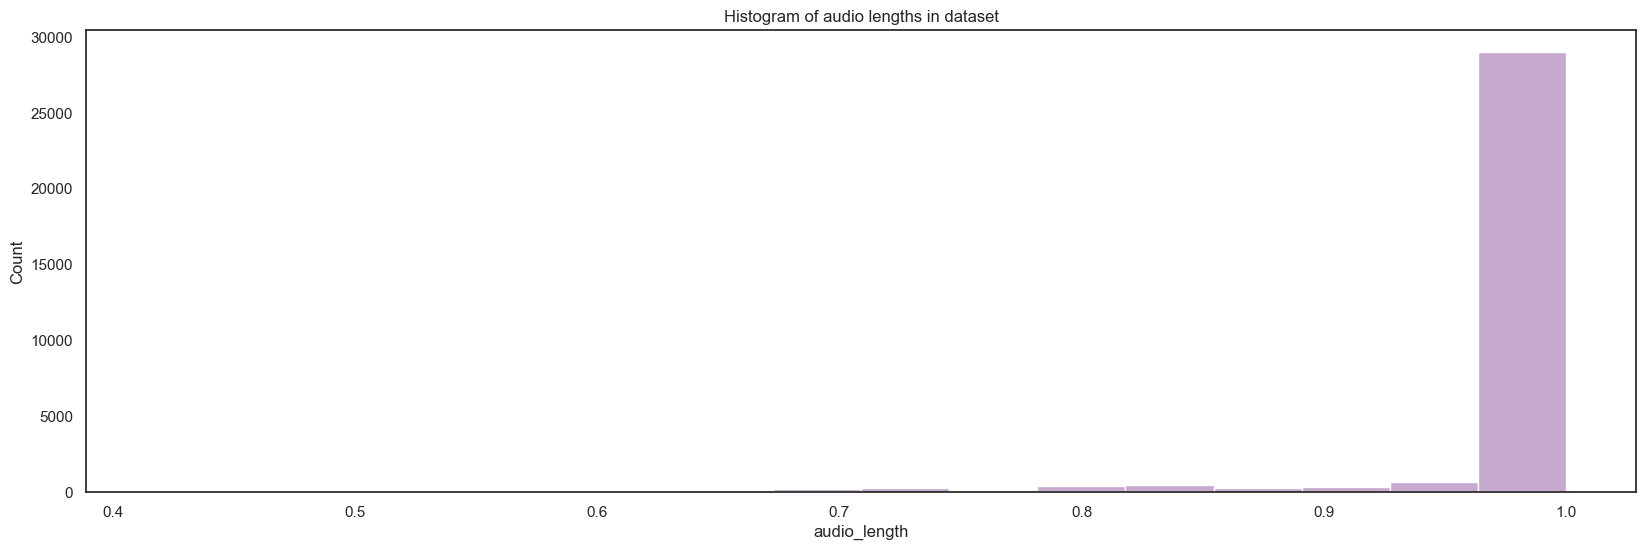

In [463]:
sns.histplot(df, x="audio_length", color="#B28CBF").set_title('Histogram of audio lengths in dataset')

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Balance of classes
    </div>

In [445]:
classes_id = [spec.class_id for spec in spectrogram_data_denoised]
df_classes_id = pd.DataFrame({'class_id' : [0, 1], 'count' : [len(classes_id) - np.count_nonzero(classes_id), np.count_nonzero(classes_id)]})

In [448]:
speakers_id = [spec.speaker_id for spec in spectrogram_data_denoised]

In [452]:
print(f"Spectrogram files: {len(spectrogram_data_denoised)}")
print(f"Number of unique speakers: {len(np.unique(speakers_id))}")

Spectrogram files: 8420
Number of unique speakers: 1679


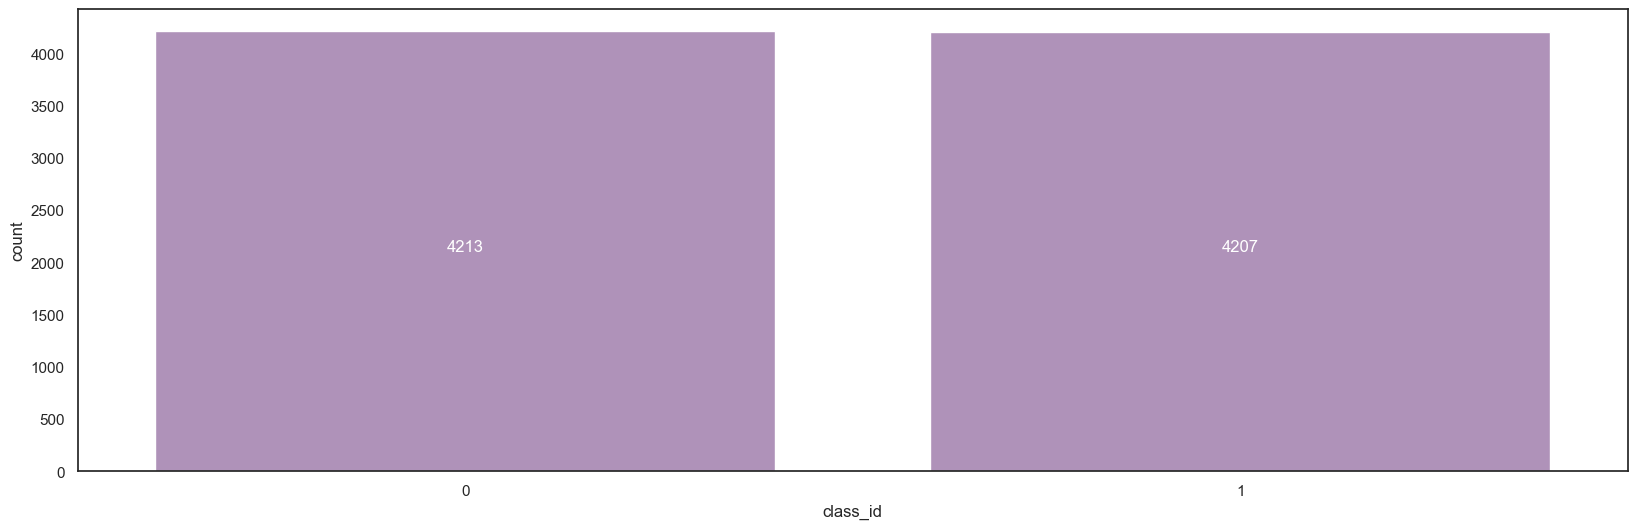

In [446]:
ax = sns.barplot(df_classes_id, x="class_id", y="count", color="#B28CBF")
for i, v in enumerate(df_classes_id['count']):
   ax.text(i, v/2, str(v), ha='center', color='white')

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Prepering mean histograms
    </div>

In [384]:
def mean_color_histogram(spectrogram_data : list, black_threshold):
    class_0_count  = len([sd for sd in spectrogram_data if sd.class_id == 0])
    class_1_count  = len([sd for sd in spectrogram_data if sd.class_id == 1])

    class_0_histograms = {'r' : [], 'g' : [], 'b' : []}
    class_1_histograms = {'r' : [], 'g' : [], 'b' : []}

    for sd in tqdm(spectrogram_data):

        hist = color_histogram(sd.file_path, black_threshold=black_threshold)

        if sd.class_id == 0:
            class_0_histograms['r'].append(hist[0])
            class_0_histograms['g'].append(hist[1])
            class_0_histograms['b'].append(hist[2])
        else:
            class_1_histograms['r'].append(hist[0])
            class_1_histograms['g'].append(hist[1])
            class_1_histograms['b'].append(hist[2])
    
    mean_color_histogram_0 = {}
    mean_color_histogram_1 = {}
    
    for color in ['r', 'g', 'b']:
        if len(class_0_histograms[color]) > 0:
            mean_color_histogram_0[color] = np.mean(np.hstack(class_0_histograms[color]), axis = 1)
        if len(class_1_histograms[color]) > 0:
            mean_color_histogram_1[color] = np.mean(np.hstack(class_1_histograms[color]), axis = 1)
    
    return mean_color_histogram_0, mean_color_histogram_1

def mean_grey_histogram(spectrogram_data : list, black_threshold):
    class_0_count  = len([sd for sd in spectrogram_data if sd.class_id == 0])
    class_1_count  = len([sd for sd in spectrogram_data if sd.class_id == 1])

    class_0_histograms = []
    class_1_histograms = []

    for sd in tqdm(spectrogram_data):

        hist = grey_histogram(sd.file_path, black_threshold=black_threshold)

        if sd.class_id == 0:
            class_0_histograms.append(hist)
        else:
            class_1_histograms.append(hist)
    
    if len(class_0_histograms) > 0:
        mean_histogram_0 = np.mean(np.hstack(class_0_histograms), axis = 1)
    if len(class_1_histograms) > 0:
        mean_histogram_1 = np.mean(np.hstack(class_1_histograms), axis = 1)
    
    return mean_histogram_0, mean_histogram_1

In [382]:
mean_color_histogram_0, mean_color_histogram_1 = mean_color_histogram(spectrogram_data_raw, 5)

100%|█████████████████████████████████████████████████████████████████████████████| 9829/9829 [00:52<00:00, 188.01it/s]


In [400]:
mean_color_histogram_processed_0, mean_color_histogram_processed_1 = mean_color_histogram(spectrogram_data_denoised, 5)

100%|█████████████████████████████████████████████████████████████████████████████| 8420/8420 [00:40<00:00, 206.86it/s]


In [385]:
mean_grey_histogram_0, mean_grey_histogram_1 = mean_grey_histogram(spectrogram_data_raw, 5)

100%|█████████████████████████████████████████████████████████████████████████████| 9829/9829 [00:27<00:00, 356.76it/s]


In [392]:
mean_grey_histogram_processed_0, mean_grey_histogram_processed_1 = mean_grey_histogram(spectrogram_data_denoised, 5)

100%|█████████████████████████████████████████████████████████████████████████████| 8420/8420 [00:38<00:00, 219.44it/s]


<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Mean color histogram (all colors before denoising) class 0 vs class 1
    </div>

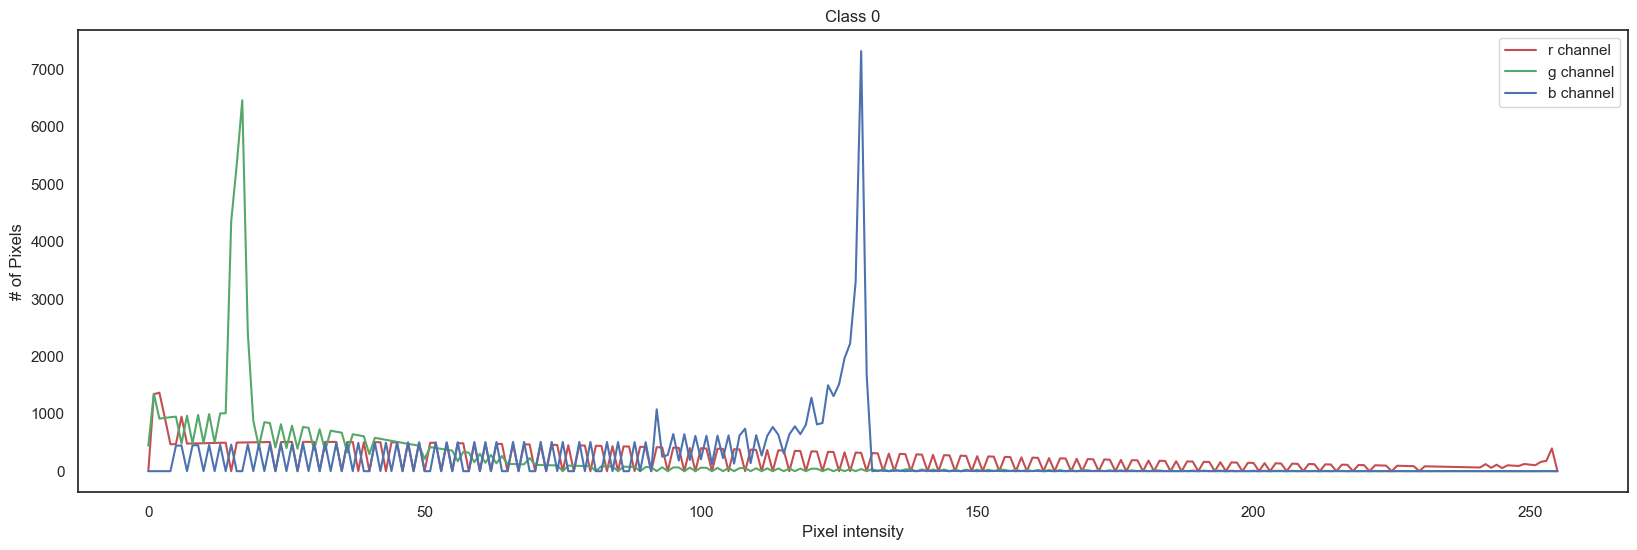

In [459]:
for color in ['r', 'g', 'b']:
    plt.plot(mean_color_histogram_0[color], color=color, label=f"{color} channel")

plt.legend()
plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 0")
plt.show()

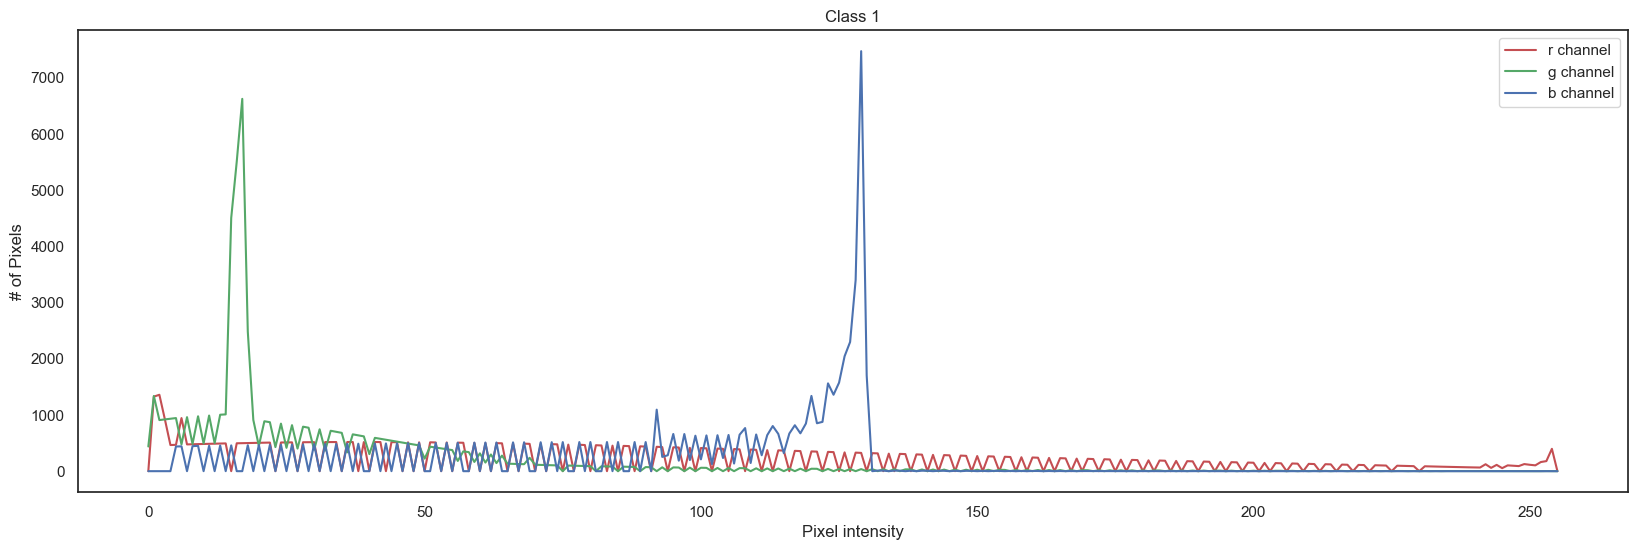

In [460]:
for color in ['r', 'g', 'b']:
    plt.plot(mean_color_histogram_1[color], color=color, label=f"{color} channel")

plt.legend()
plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 1")
plt.show()

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Mean color histogram (all colors after denoising) class 0 vs class 1
    </div>

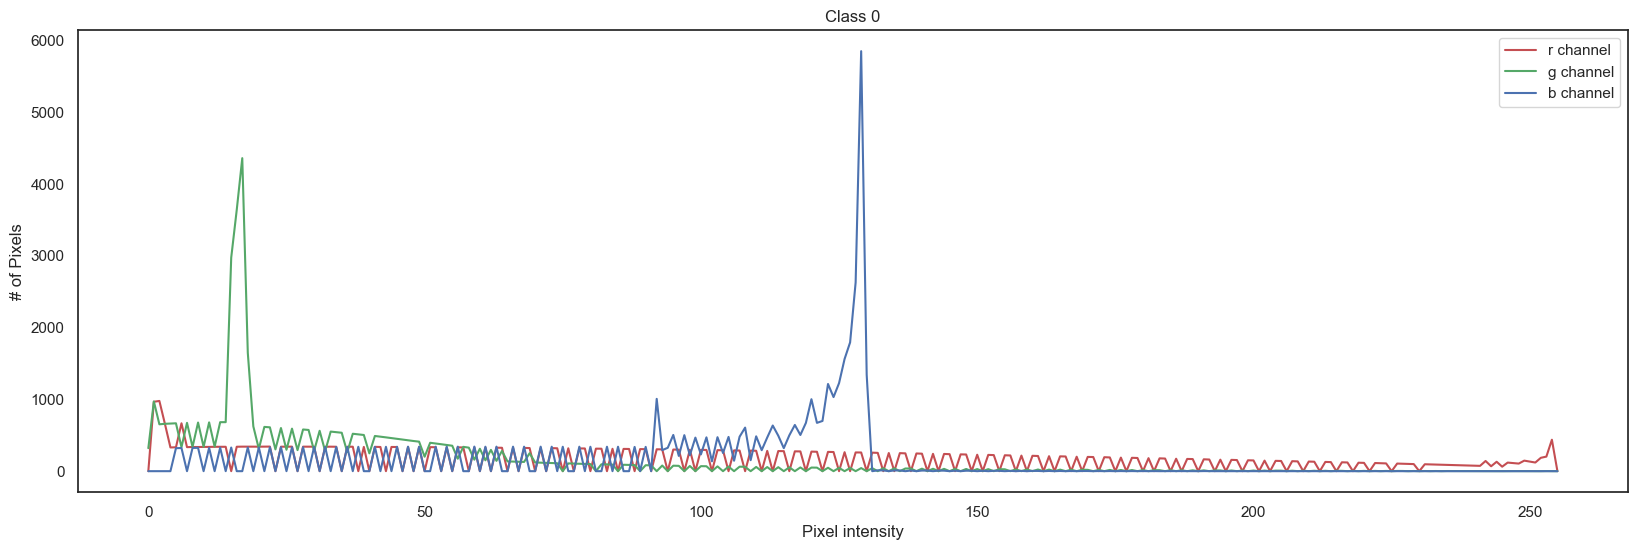

In [430]:
for color in ['r', 'g', 'b']:
    plt.plot(mean_color_histogram_processed_0[color], color=color, label=f"{color} channel")

plt.legend()
plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 0")
plt.show()

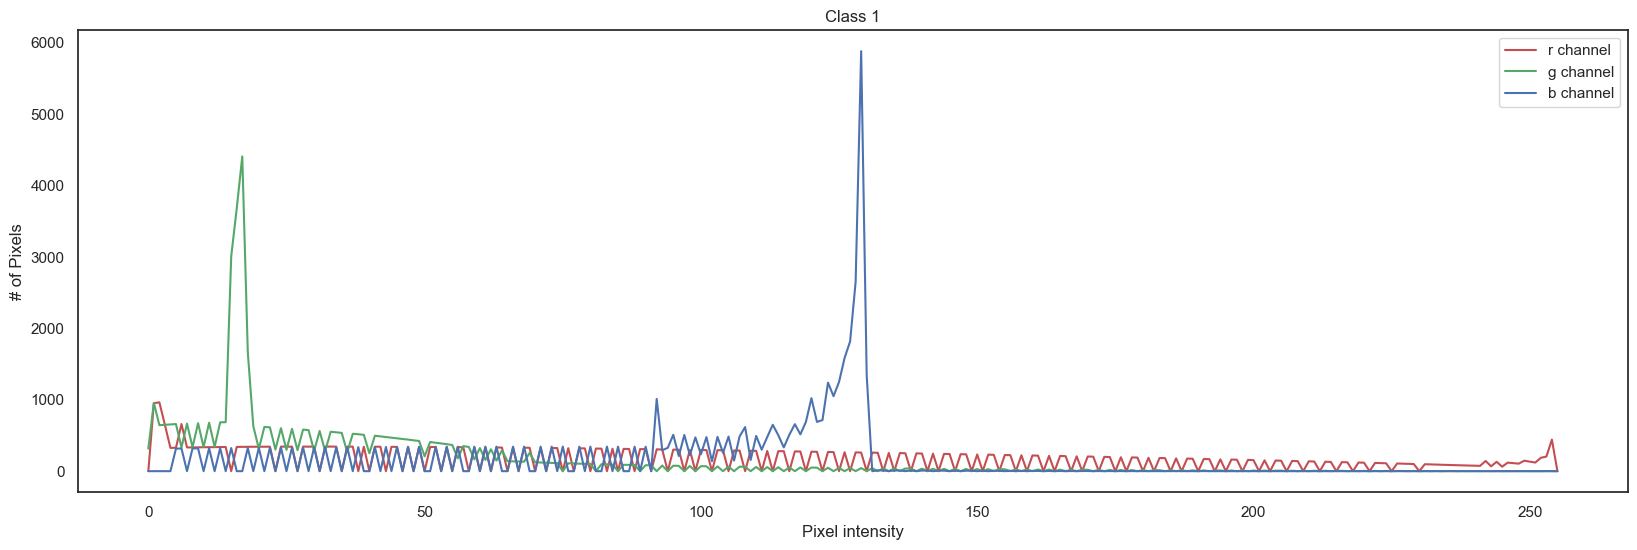

In [431]:
for color in ['r', 'g', 'b']:
    plt.plot(mean_color_histogram_processed_1[color], color=color, label=f"{color} channel")

plt.legend()
plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 1")
plt.show()

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Mean color histogram (red before and after denoising) class 0 vs class 1
    </div>

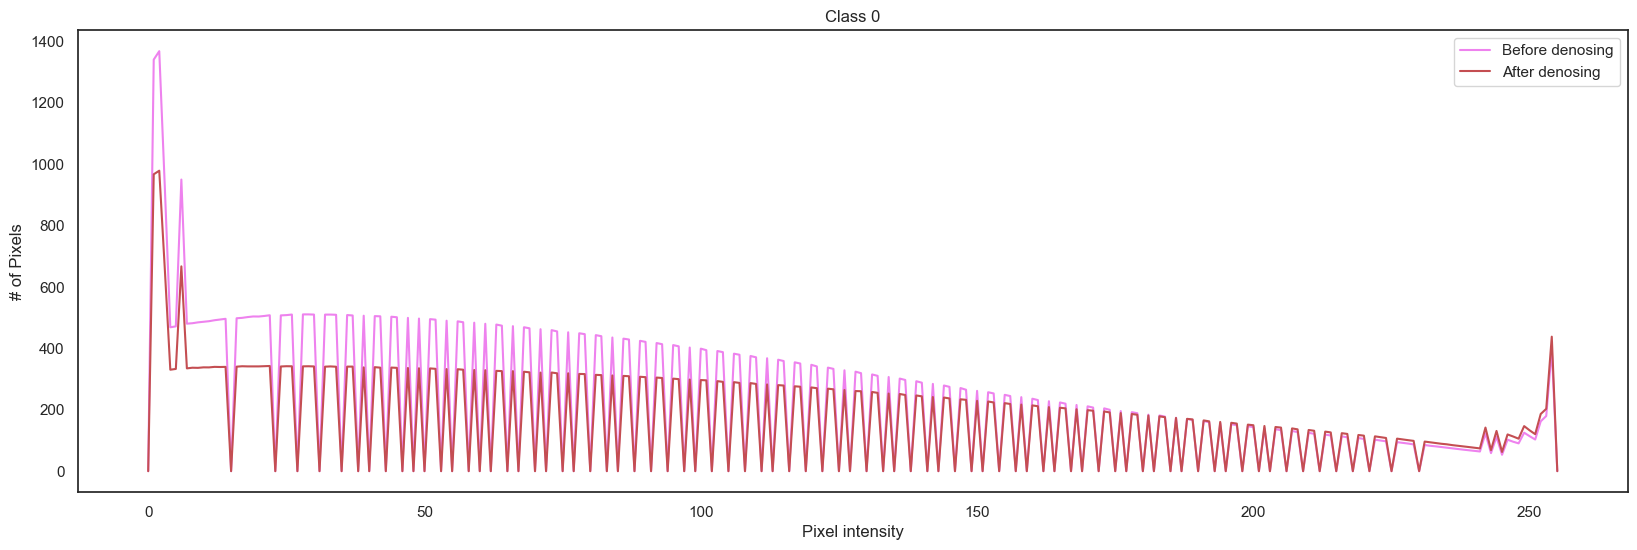

In [421]:
color = 'r'
plt.plot(mean_color_histogram_0[color], color = 'violet', label = 'Before denosing')
plt.plot(mean_color_histogram_processed_0[color], color = color, label = 'After denosing')
plt.legend()

plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 0")
plt.show()

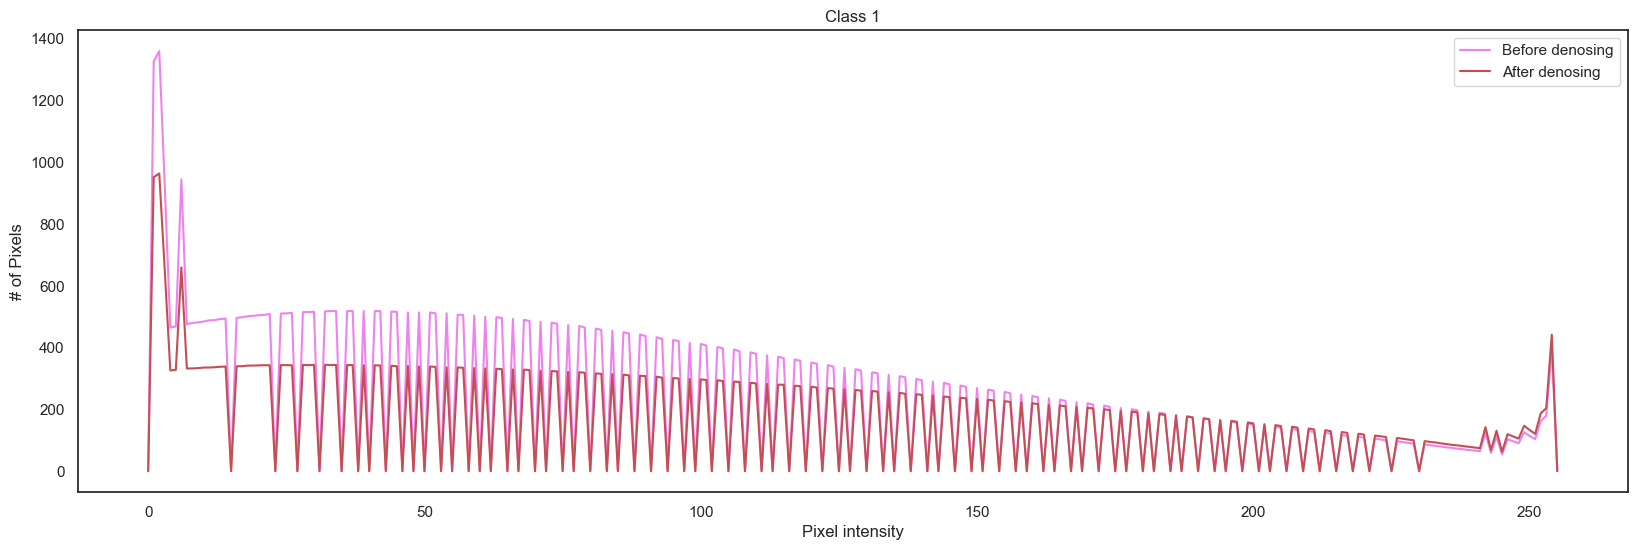

In [422]:
color = 'r'
plt.plot(mean_color_histogram_1[color], color = 'violet', label = 'Before denosing')
plt.plot(mean_color_histogram_processed_1[color], color = color, label = 'After denosing')
plt.legend()

plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 1")
plt.show()

In [274]:
metrics.mean_absolute_error(mean_color_histogram_0[color], mean_color_histogram_1[color])

3.720252

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Mean color histogram (green before and after denoising) class 0 vs class 1
    </div>

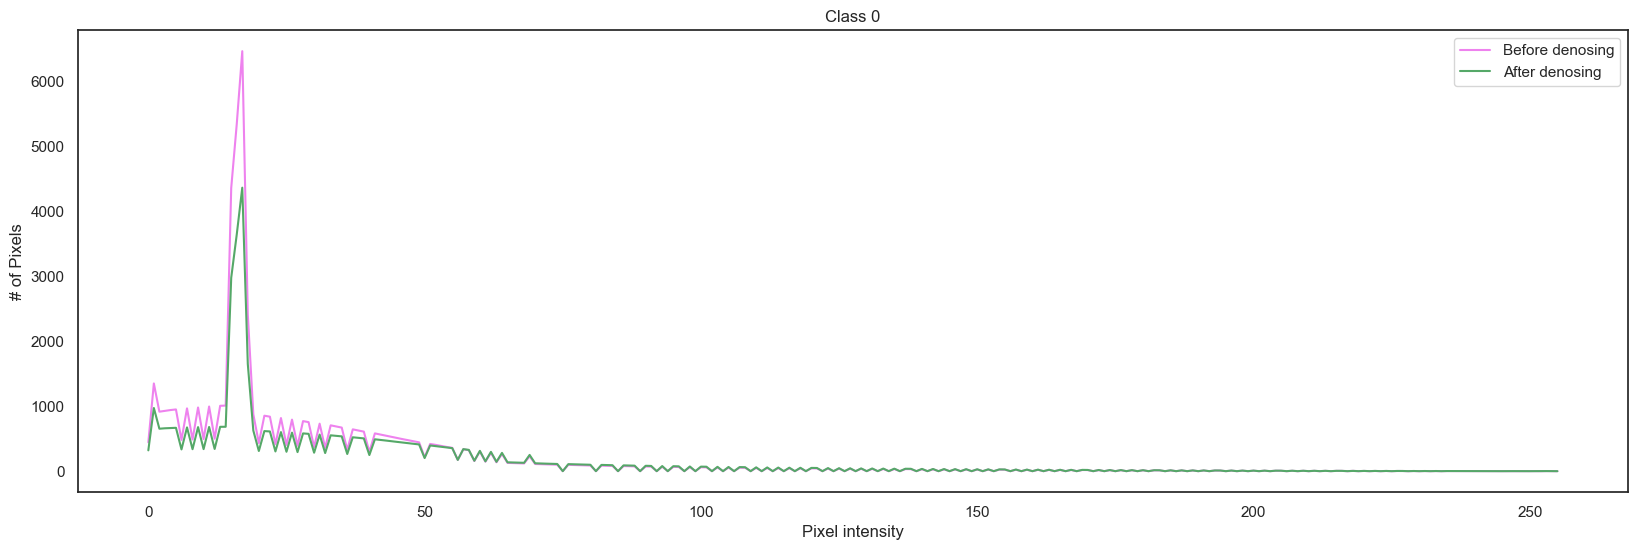

In [423]:
color = 'g'
plt.plot(mean_color_histogram_0[color], color = 'violet', label = 'Before denosing')
plt.plot(mean_color_histogram_processed_0[color], color = color, label = 'After denosing')
plt.legend()

plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 0")
plt.show()

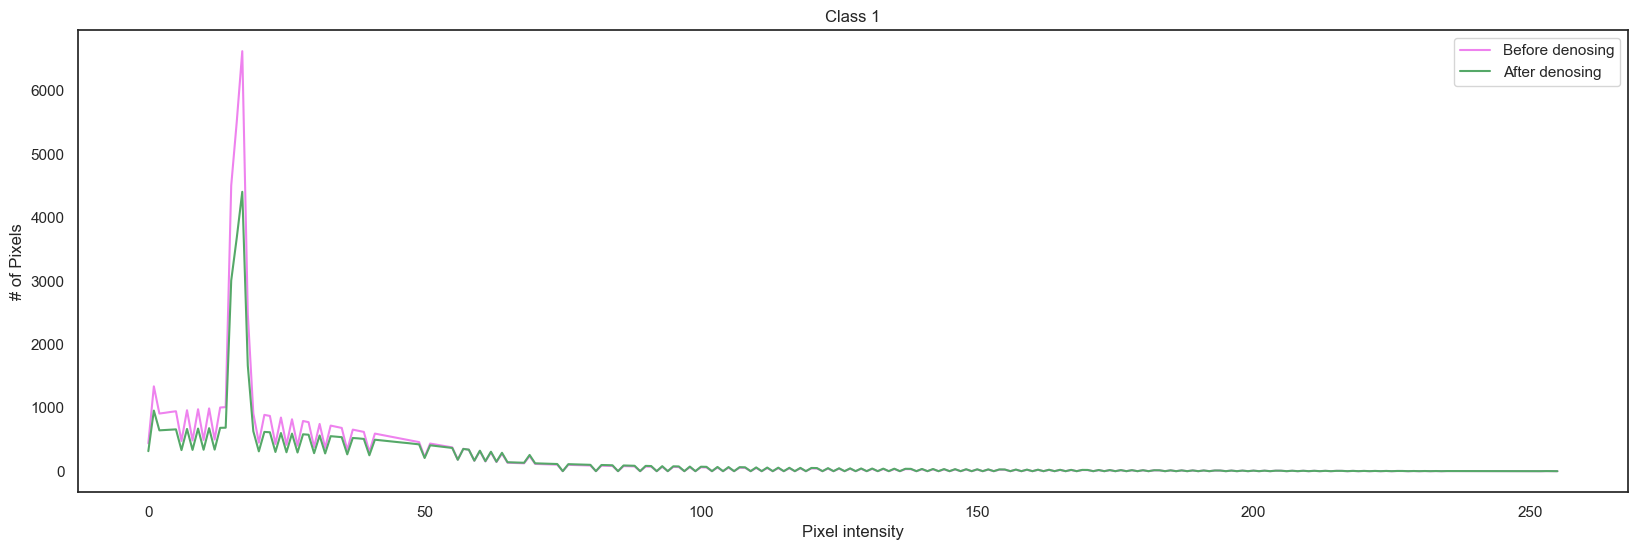

In [424]:
color = 'g'
plt.plot(mean_color_histogram_1[color], color = 'violet', label = 'Before denosing')
plt.plot(mean_color_histogram_processed_1[color], color = color, label = 'After denosing')
plt.legend()

plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 1")
plt.show()

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Mean color histogram (blue before and after denoising) class 0 vs class 1
    </div>

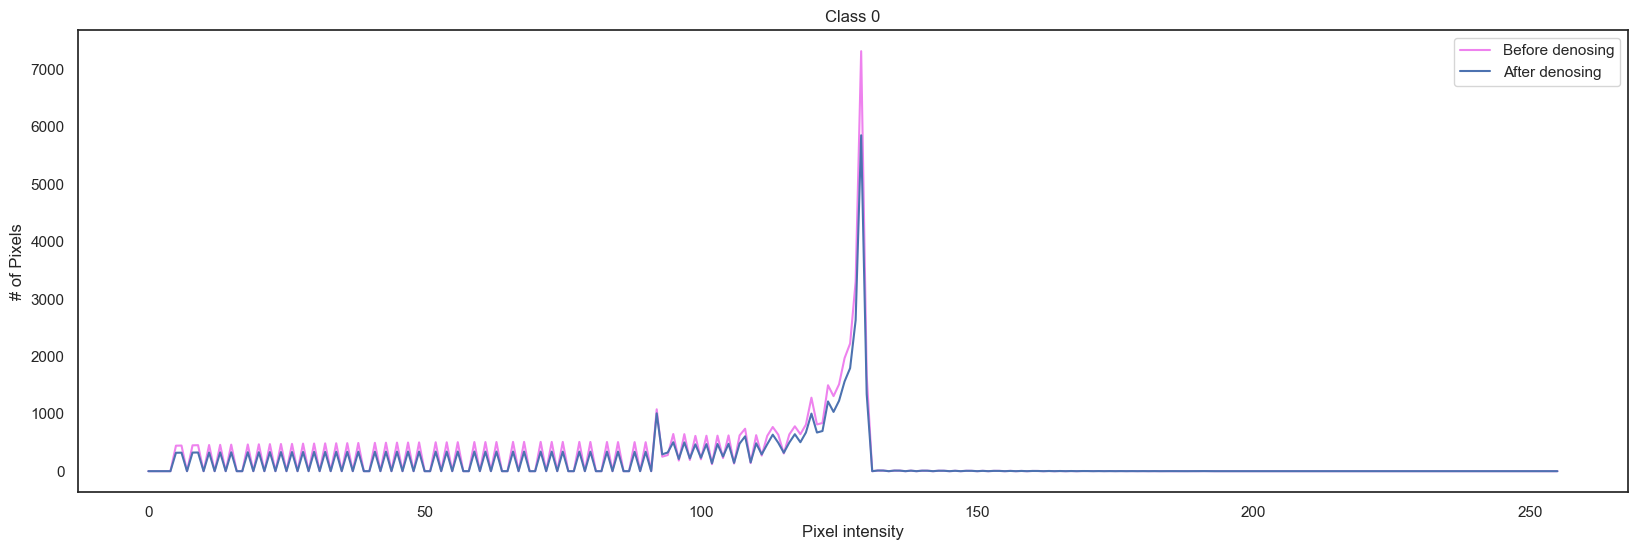

In [425]:
color = 'b'
plt.plot(mean_color_histogram_0[color], color = 'violet', label = 'Before denosing')
plt.plot(mean_color_histogram_processed_0[color], color = color, label = 'After denosing')
plt.legend()

plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 0")
plt.show()

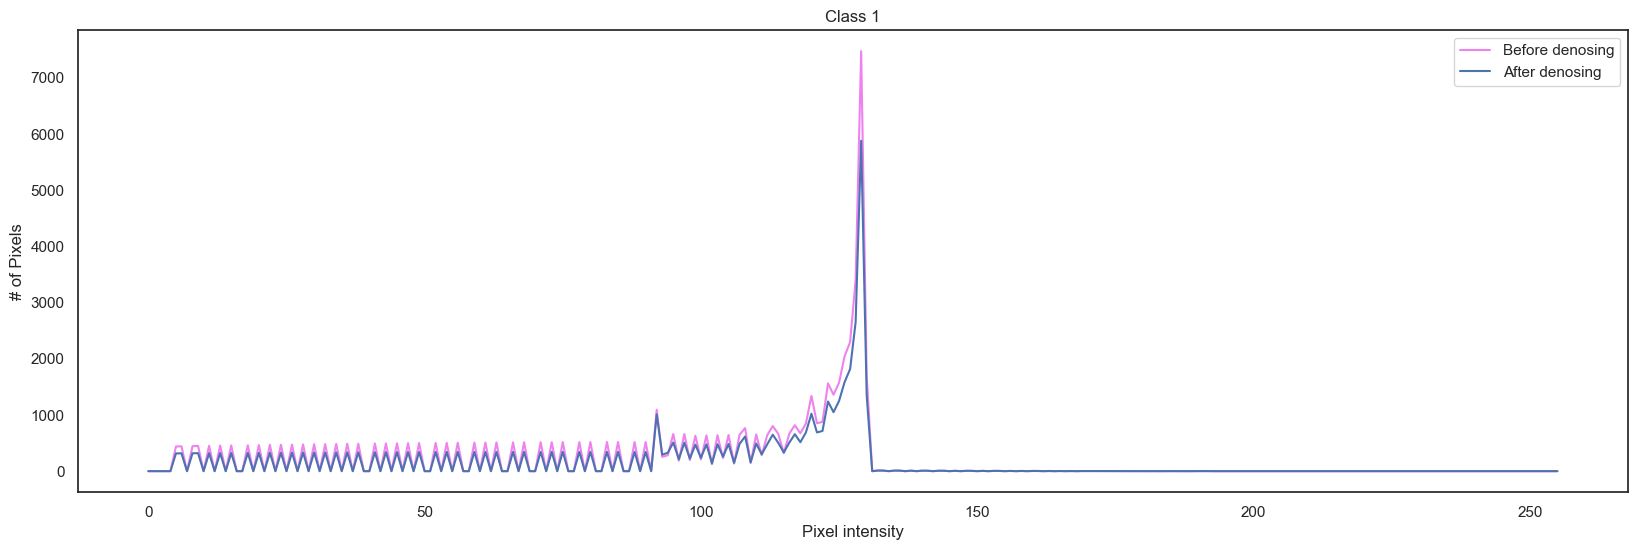

In [426]:
color = 'b'
plt.plot(mean_color_histogram_1[color], color = 'violet', label = 'Before denosing')
plt.plot(mean_color_histogram_processed_1[color], color = color, label = 'After denosing')
plt.legend()

plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 1")
plt.show()

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Mean grey histogram class 0 vs class 1
    </div>

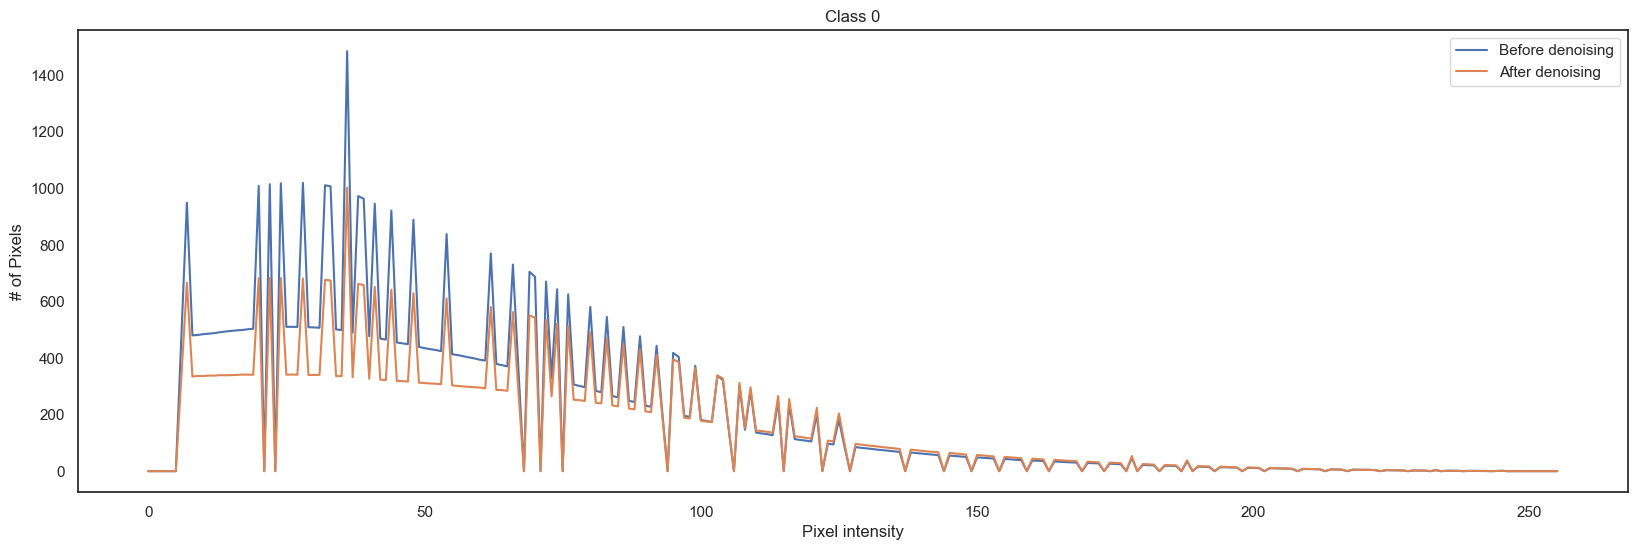

In [398]:
plt.plot(mean_grey_histogram_0, label='Before denoising')
plt.plot(mean_grey_histogram_processed_0, label='After denoising')
plt.legend()

plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 0")
plt.show()

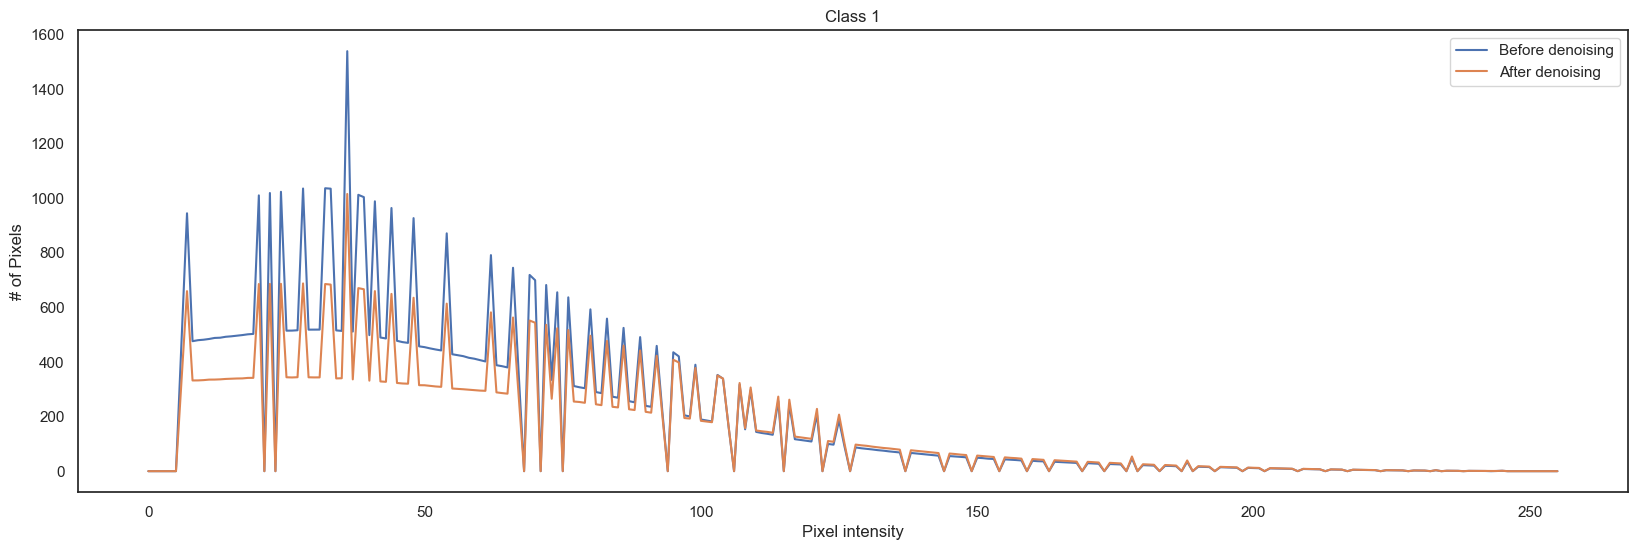

In [399]:
plt.plot(mean_grey_histogram_1, label='Before denoising')
plt.plot(mean_grey_histogram_processed_1, label='After denoising')
plt.legend()

plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 1")
plt.show()

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Examples of histograms - one recording, same speaker (before and after denoising)
    </div>

In [365]:
unique_speakers = np.unique([spec.speaker_id for spec in spectrogram_data_denoised])

i = 3
speaker_1_raw = [spec for spec in spectrogram_data_raw if spec.speaker_id == unique_speakers[i]]
speaker_1_denoise = [spec for spec in spectrogram_data_denoised if spec.speaker_id == unique_speakers[i]]

In [435]:
speaker_1 = [spec for spec in spectrogram_data_raw if spec.speaker_id == unique_speakers[0]]
speaker_1_denoised = [spec for spec in spectrogram_data_denoised if spec.speaker_id == unique_speakers[0]]
speaker_2 = [spec for spec in spectrogram_data_raw if spec.speaker_id == unique_speakers[1]]
speaker_2_denoised = [spec for spec in spectrogram_data_denoised if spec.speaker_id == unique_speakers[1]]

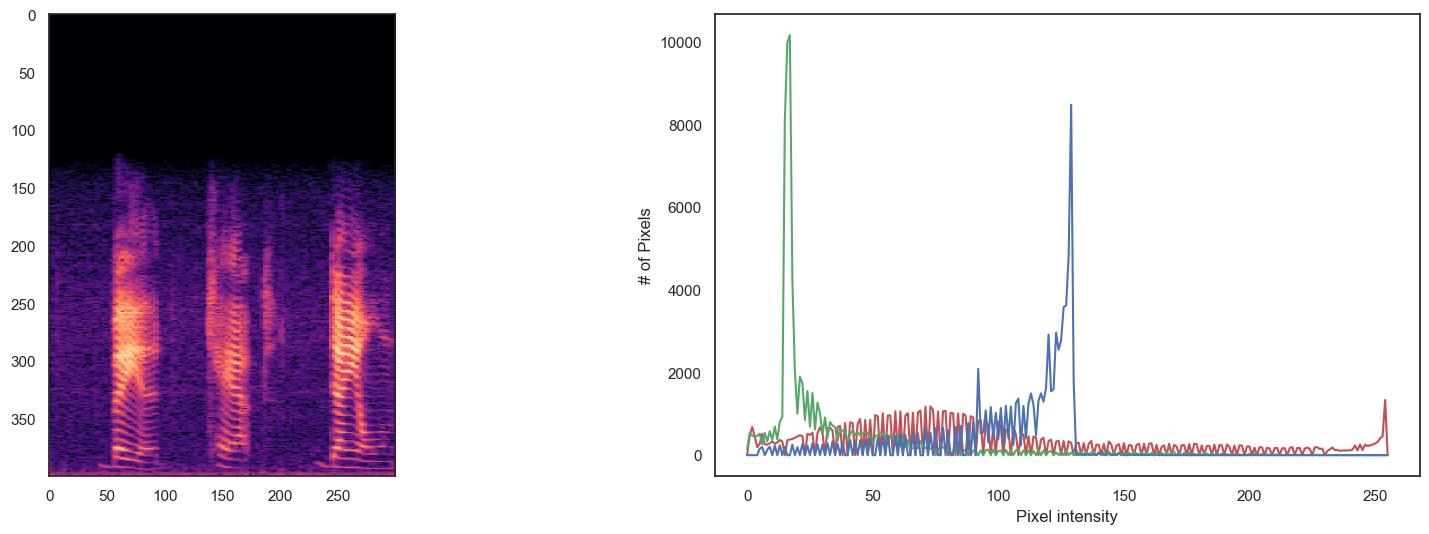

In [437]:
plot_color_histogram(speaker_1[0].file_path, black_threshold=5)

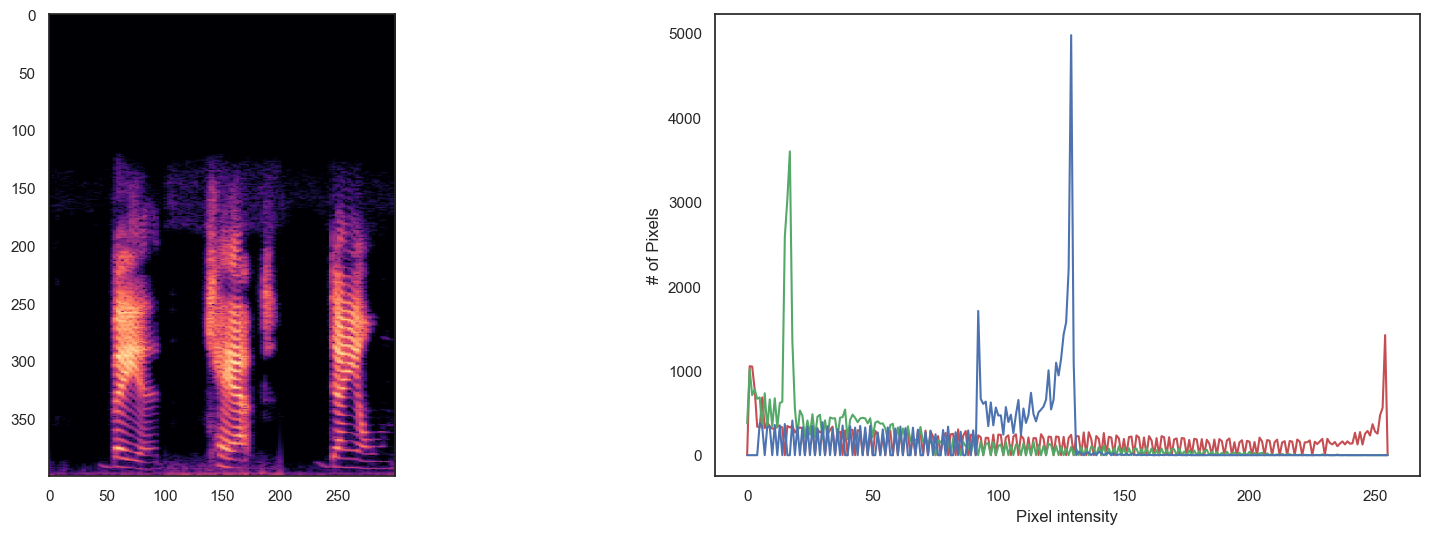

In [441]:
plot_color_histogram(speaker_1_denoised[0].file_path, black_threshold=5)

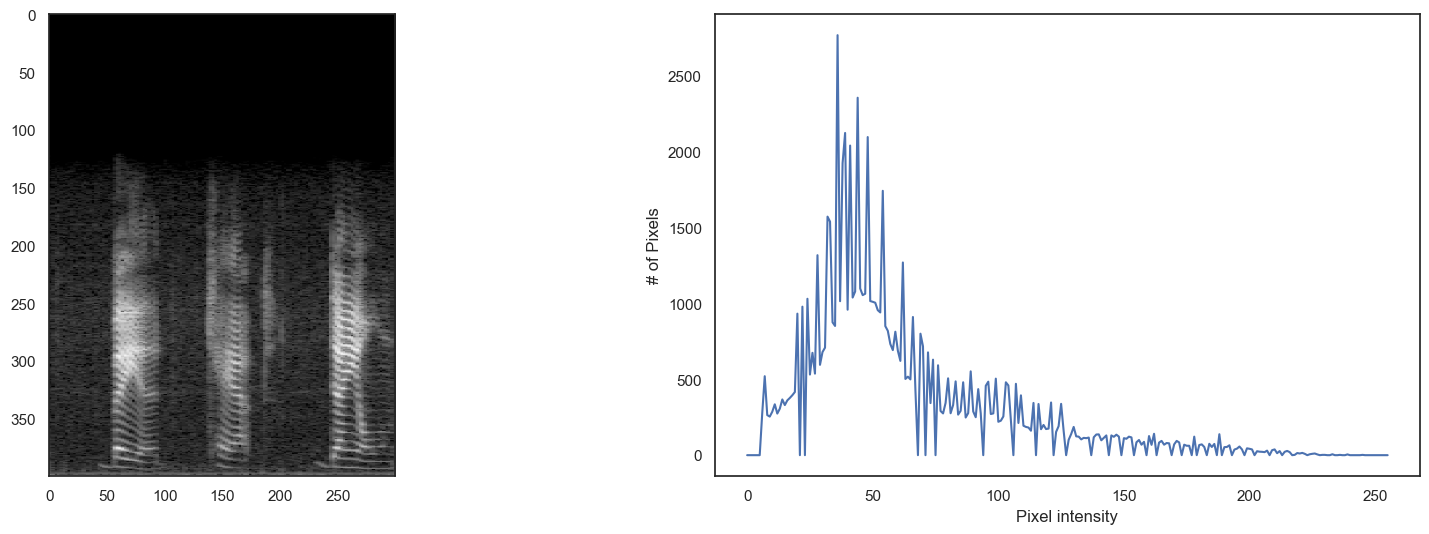

In [ ]:
plot_grey_histogram(speaker_1[0].file_path, black_threshold=5)

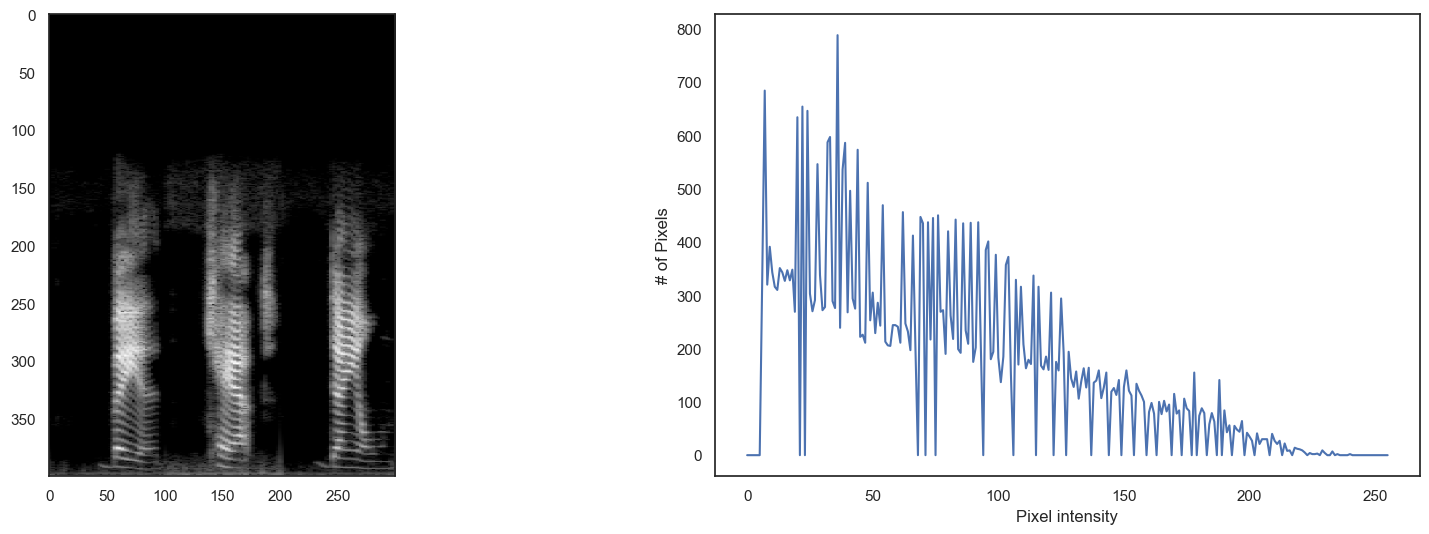

In [442]:
plot_grey_histogram(speaker_1_denoised[0].file_path, black_threshold=5)

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Examples of histograms - two recordings, different speakers (after denoising)
    </div>

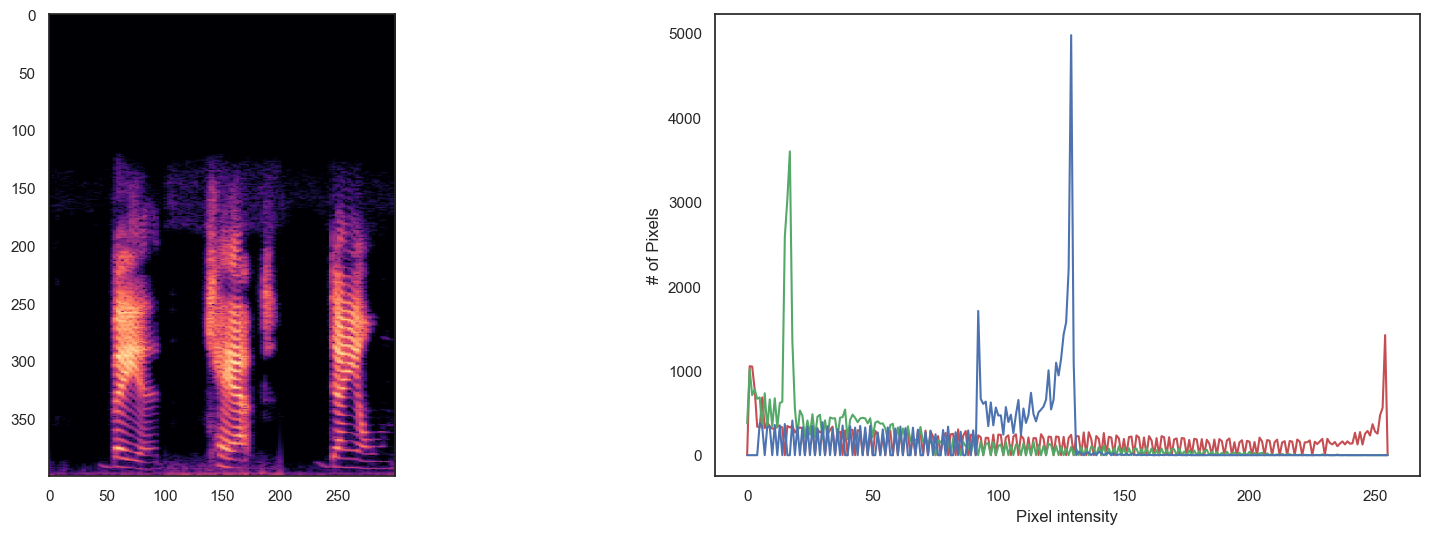

In [443]:
plot_color_histogram(speaker_1_denoised[0].file_path, black_threshold=5)

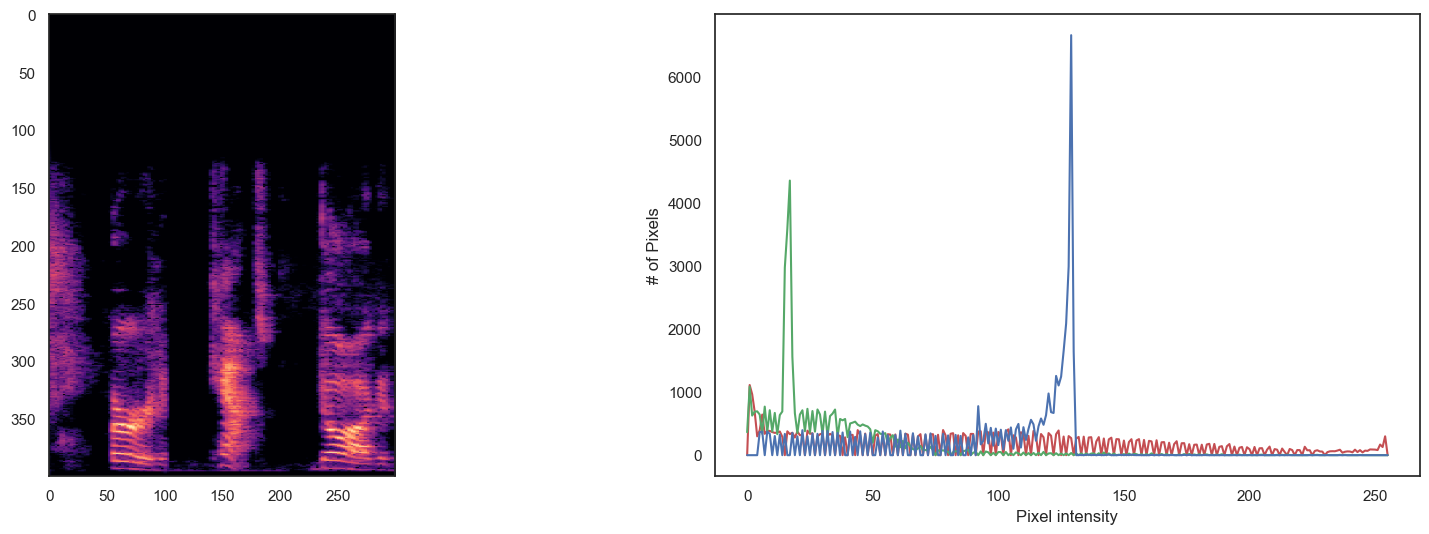

In [444]:
plot_color_histogram(speaker_2_denoised[0].file_path, black_threshold=5)

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Color histograms
    </div>

In [3]:
import cv2
import os

mypath = "../data/tsrc_sprectrograms/train/0/"

In [24]:
sns.set_theme(context='notebook', style = "white", palette=None)

In [184]:
class SpectrogramData():
    def __init__(self, file_path : str, speaker_id : str, recording_no : int , train_validaton_test : str, class_id : int):
        self.file_path = file_path
        self.speaker_id = speaker_id
        self.recording_no = recording_no
        self.train_validaton_test = train_validaton_test
        self.class_id = class_id

class SpectrogramLoader():
        
    @staticmethod
    def load_data(path):
        objects_list = []
        
        for subdir, dirs, files in os.walk(path):
            if dirs is not None:
                for file in files:
                    file_path = os.path.join(subdir, file)
                    file_path = os.path.normpath(file_path)
                    #print(file_path)
                    #print(file_path.split('\\'))
                    class_id = file_path.split('\\')[-2]
                    train_validaton_test = file_path.split('\\')[-3]
                    speaker_id = file[:8]
                    recording_no = file.removesuffix(".png").split("_")[1]

                    data_object = SpectrogramData(file_path=file_path,
                                                  speaker_id=speaker_id,
                                                  recording_no=int(recording_no),
                                                  train_validaton_test=train_validaton_test,
                                                  class_id=int(class_id))
                    objects_list.append(data_object)
        
        return objects_list

In [178]:
spectrogram_data = SpectrogramLoader().load_data("../data/tsrc_sprectrograms/")

In [179]:
spectrogram_data[0].recording_no

0

In [182]:
def colorHistogram(file_path, black_threshold):
    img = cv2.imread(file_path)
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #plt.figure()
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(imgRGB)
    
    colors = ['r', 'g', 'b']
    #plt.figure()
    
    mask = np.logical_not(np.all(imgRGB < black_threshold, axis=2)).astype(np.uint8)
    for i, color in enumerate(colors):
        hist = cv2.calcHist([imgRGB], [i], mask, [256], [0,256])
        axes[1].plot(hist, color,)
        
    plt.xlabel("Pixel intensity")
    plt.ylabel("# of Pixels")
    plt.show()
        

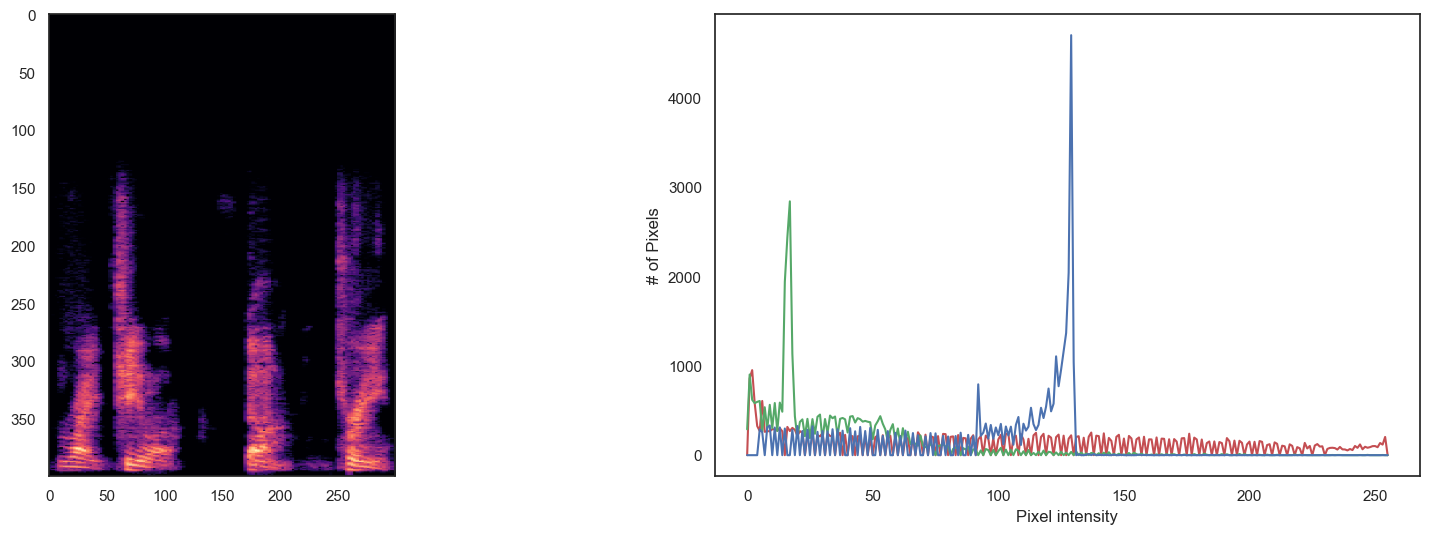

In [183]:
colorHistogram(mypath+f[13], black_threshold = 5)

In [ ]:
[]